In [1]:
from src.functions.compute_angular_profiles import compute_angular_profiles
from src.functions.langevin_gillespie import langevin_gillespie
import numpy as np
import math
import matplotlib.pyplot as plt

In [2]:
# Step One: Initialize Parameters
# Elastic Constants
kappa = 56  # pN.nm/rad^2
ktrap = 240  # pN.nm/rad^2

# Thermal Energy at room temperature
kBT = 4.14  # pN.nm

# Unknown Terms (Look at paper)
r = 19  # nm
a = 20  # nm

# Viscosity and drag terms for rotational friction
eta = 1e-9  # pN.s/nm^2
gammaB = 8 * math.pi * eta * math.pow(a, 3) + 6 * math.pi * eta * a * math.pow(r, 2)

th1 = 0

# Simulation Parameters
nSim = 500  # Number of simulations
dur = 120  # Steps per simulation
dt = 1e-6  # Step size

pos = np.sqrt(kBT / (10 * kappa)) * np.random.randn(nSim) + th1

method = "heun"

In [3]:
# np.random.seed(42)  # Set Seed for reproducibility
pos_store, state_store, theta_store = langevin_gillespie(nSim, dur, dt, pos, gammaB, kappa, kBT, method)  # Step Two: Langevin - Gillespie // Get Data

In [4]:
profile, jump_pdf, profile_coarse, jump_pdf_coarse = compute_angular_profiles(dt, pos_store, state_store)  # Step 2a: Angular Profiles

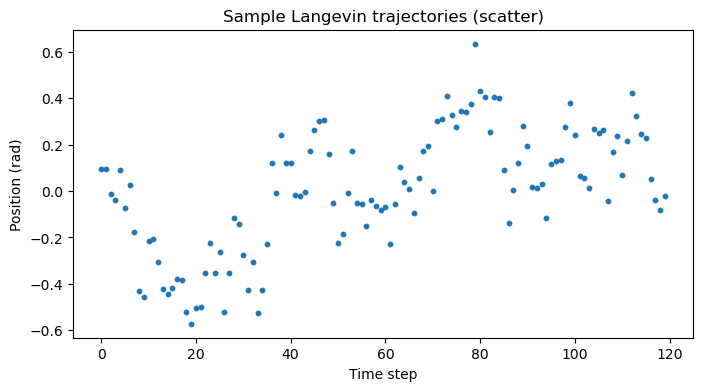

In [5]:
# Step Three: Visualize Data
plt.figure(figsize=(8, 4))
time = np.arange(pos_store.shape[0])  # time steps
for k in range(min(1, nSim)):  
    plt.scatter(time, pos_store[:, k], s=10, alpha=1,)  
plt.xlabel("Time step")
plt.ylabel("Position (rad)")
plt.title("Sample Langevin trajectories (scatter)")
plt.show()


Text(0.5, 1.0, 'Sample Langevin trajectories')

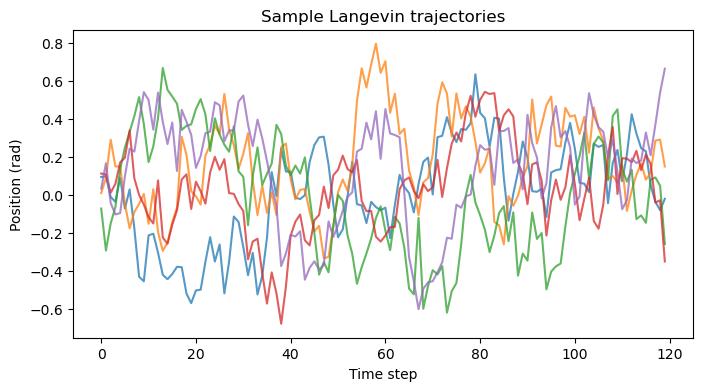

In [6]:
plt.figure(figsize=(8, 4))
for k in range(min(5, nSim)):
    plt.plot(pos_store[:, k], alpha=0.75)
plt.xlabel("Time step")
plt.ylabel("Position (rad)")
plt.title("Sample Langevin trajectories")

Text(0.5, 1.0, 'Distribution of final positions')

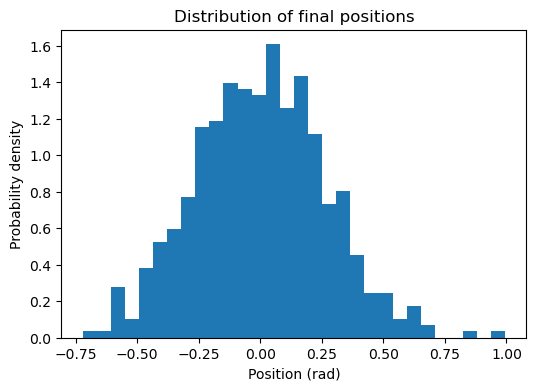

In [7]:
plt.figure(figsize=(6, 4))
plt.hist(pos_store[-1, :], bins=30, density=True)
plt.xlabel("Position (rad)")
plt.ylabel("Probability density")
plt.title("Distribution of final positions")


Text(0.5, 1.0, 'Mean trajectory over all simulations')

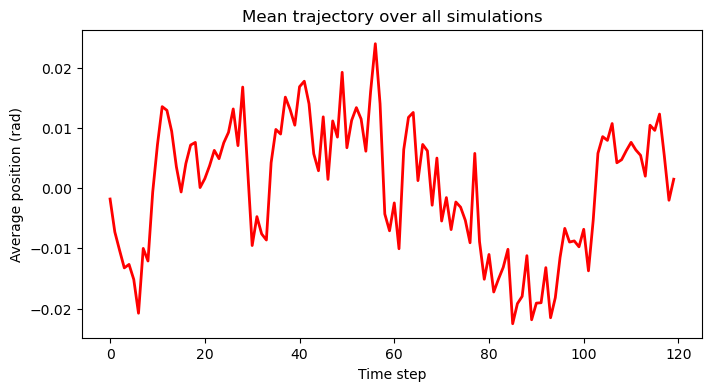

In [8]:
mean_pos = pos_store.mean(axis=1)

plt.figure(figsize=(8, 4))
plt.plot(mean_pos, color="red", linewidth=2)
plt.xlabel("Time step")
plt.ylabel("Average position (rad)")
plt.title("Mean trajectory over all simulations")

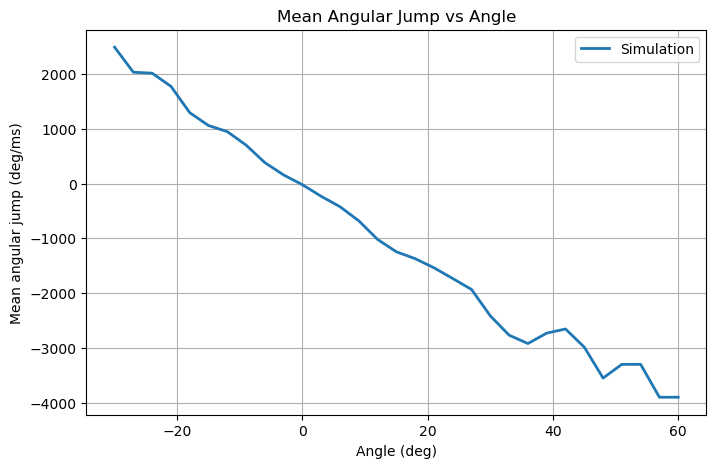

In [9]:
plt.figure(figsize=(8,5))

# Use the coarse profile for smoother line
plt.plot(profile_coarse[:, 0], profile_coarse[:, 1], label="Simulation", linewidth=2)

plt.xlabel("Angle (deg)")
plt.ylabel("Mean angular jump (deg/ms)")
plt.title("Mean Angular Jump vs Angle")
plt.legend()
plt.grid(True)